In [ ]:
!pip install torchvision

In [6]:
__author__ = "Lech Szymanski"
__organization__ = "COSC420, University of Otago"
__email__ = "lech.szymanski@otago.ac.nz"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
   import torch
   torch_lib = True
except:
   torch_lib = False
   
import time

def show_data_attributes(inputs, labels,attribute_names,class_names):
   # Create a figure
   figure_handle = plt.figure()

   n_attributes = inputs.shape[1]
   n_plots = int(n_attributes*(n_attributes-1)/2)
   n_plot_rows = int(np.floor(np.sqrt(n_plots)))
   n_plot_columns = int(np.ceil(n_plots/n_plot_rows))

   # Plot each dimension against another dimension
   n_classes = len(class_names)
   plot_index = 1
   for i in range(n_attributes):
       for j in range(i+1,n_attributes):
           # Add subplot to the figure
           plot_handle = figure_handle.add_subplot(n_plot_rows, n_plot_columns, plot_index)
           # Do a scatter plot for each class separately (matplotlib automatically does them in different colours)
           for k in range(n_classes):
               # Find all the indexes of points of class k
               I = np.where(labels==k)[0]
               # Show a scatter plot of dimension i vs. dimension j of the points of class k
               plot_handle.scatter(inputs[I,i],inputs[I,j])
           # Increments the plot_index variable
           plot_index += 1
           # Label the x and y axis
           plot_handle.set_xlabel(attribute_names[i])
           plot_handle.set_ylabel(attribute_names[j])

   # Show the legend for class colours on the last subplot
   plot_handle.legend(class_names)


def show_data_images(images, labels=None, predictions=None, class_names=None,blocking=True):

   if torch_lib and torch.is_tensor(images):
      images = images.numpy()
      # Torch images are in the shape (N, C, H, W) where N is the number of images, C is the number of channels, H is the height, whereas the show methods expect (N, H, W, C) shape...so we transpose switching the last two dimensions
      images = np.transpose(images, (0, 2, 3, 1))
      if len(images.shape) == 4 and images.shape[3] == 1:
         images = np.squeeze(images, axis=3)

      if labels is not None and torch.is_tensor(labels):
         labels = labels.numpy()

   # Create a figure
   figure_handle = plt.figure(figsize=(6,8))
   n_images = len(images)
   n_plot_rows = int(np.floor(np.sqrt(n_images)))
   n_plot_columns = int(np.ceil(n_images/n_plot_rows))

   plt.ion()

   # Plot each dimension against another dimension
   for i in range(n_plot_rows * n_plot_columns):
      plot_handle = figure_handle.add_subplot(n_plot_rows, n_plot_columns, i + 1)
      if len(np.shape(images)) == 3:
         plot_handle.imshow(images[i, :, :], cmap='gray')
      else:
         plot_handle.imshow(images[i, :, :,:])

      plot_handle.tick_params(bottom=False, left=False)
      plot_handle.tick_params(labelbottom=False, labelleft=False)

      titleStr = ''
      if labels is not None:
         if class_names is not None:
            if len(labels.shape) == 1:
               titleStr += 'label: %s' % class_names[labels[i]]
            else:
               titleStr = ''
               for j in labels[i]:
                  if j<len(class_names):
                     titleStr += '%s, ' % class_names[j]
               titleStr = titleStr[:-2]
         elif isinstance(labels[i],list) and len(labels[i])==3:
            titleStr = ''
            firstLabel = True
            for label in labels[i]:
               if firstLabel:
                  firstLabel = False
               else:
                  titleStr += '\n'
               titleStr += '%s (%.2f)' % (label[1],label[2])






      if predictions is not None:
         if labels is not None:
            titleStr += '\n'

         titleStr += 'pred: %s' % class_names[predictions[i]]

      plot_handle.set_title(titleStr)
      plt.pause(0.01)
      plt.show()
      time.sleep(0.01)

   if blocking:
      plt.ioff()
   else:
      time.sleep(1)

   plt.show()

def show_data_classes(inputs, labels, class_names,mode='pca'):

   if len(np.shape(inputs))>2:
      n_inputs = len(inputs)
      inputs = np.reshape(inputs,(n_inputs,-1))

   # Set up PCA compression to 2D
   if mode=='pca':
      x_2D = PCA(n_components=2).fit_transform(inputs)
   elif mode=='tsne':
      x_2D = TSNE(n_components=2).fit_transform(inputs)

   # Create a new figure
   figure_handle = plt.figure()
   # Create a subplot
   plot_handle = figure_handle.add_subplot(1, 1, 1)
   # Do a scatter plot for each class separately (matplotlib automatically does them in different colours)
   for k in range(len(class_names)):
      # Find all the indexes of points of class k
      I = np.where(labels == k)[0]
      # Show a scatter plot of dimension i vs. dimension j of the points of class k
      plot_handle.scatter(x_2D[I, 0], x_2D[I, 1])

   # Show the legend for class colours
   if len(class_names) <= 10:
      plot_handle.legend(class_names)
   # Display the plot title
   plot_handle.set_title('Compressed data from %dD to 2D' % inputs.shape[1])


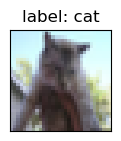

Epoch 1/50


167/450 [===>      ] - ETA: 02:45, loss: 1.8940 - acc: 0.2856


KeyboardInterrupt: 

In [7]:
__author__ = "Lech Szymanski"
__organization__ = "COSC420, University of Otago"
__email__ = "lech.szymanski@otago.ac.nz"

import torch
import torchvision
import tqdm
import matplotlib.pyplot as plt
import os, sys
import pickle, gzip

# Specify the device to be used for computations.  Choices are
# - 'cpu' - to use the CPU
# - 'cuda' to use GPU, 
# - 'mps' to use Intel MPS (on Apple Silicon)
device = torch.device('cpu')

# Change this variable to False if you don't want load the model from file
# and train it from scratch (if set to True, but the saved weights file doesn't exist,
# the model will be trained from scratch)
load_from_file = True

# Get the path to the common, data and saved folder
path_to_this_scripts_folder = "./"#os.path.dirname(os.path.realpath(__file__))
path_to_common_folder = os.path.join(path_to_this_scripts_folder, 'common')
path_to_data_folder = os.path.join(path_to_this_scripts_folder, 'data')
path_to_save_folder = os.path.join(path_to_this_scripts_folder, 'saved')

# Add common folder to the system path
sys.path.append(path_to_common_folder)

# Now we can import show_methods that are found in the common folder
# import show_methods

class CNN(torch.nn.Module):

    def __init__(self, in_channels, n_classes): 
      #Initialise the base class provided by PyTorch
      super(CNN, self).__init__()

      # Add a convolutional layer, 3x3 window, 64 filters - specify the size of the input as 32x32x3, padding="same"
      self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1)

      # Add a max pooling layer, 2x2 window
      self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

      # Add a convolutional layer, 3x3 window, 128 filters, padding="same"
      self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

      # Add a max pooling layer, 2x2 window
      self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

      # Add a convolutional layer, 3x3 window, 256 filters
      self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

      # Add a max pooling layer, 2x2 window
      self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

      # Flatten the output maps for fully connected layer
      self.flatten = torch.nn.Flatten()

      # At this point you need to work out the size of the output of the last pooling layer (before flattening).
      # You can do this by passing a dummy tensor through the network and printing the 
      # size of the output to the console.  This will give you the size of the output of the last pooling 
      # layer.  In this case, with input tensor of 3x32x32, the output of the last pooling layer is 256x4x4, 
      # which flatten layer will flatten to a total of 256*4*4 = 4096 neurons...and that's the number of
      # inputs to the following linear layer.

      # Add a fully connected layer of 128 neurons
      self.fc1 = torch.nn.Linear(4096, 128)

      # Add a fully connected layer of 512 neurons
      self.fc2 = torch.nn.Linear(128, 512)

      # Add a fully connected layer with number of output neurons the same
      # as the number of classes
      self.fc3 = torch.nn.Linear(512, n_classes)

    def forward(self, x):
      # First convolution layer followed by ReLU activation
      x = self.conv1(x)
      x = torch.relu(x)

      # Max pooling layer to reduce the size of the feature maps
      x = self.pool1(x)

      # Second convolution layer followed by ReLU activation
      x = self.conv2(x)
      x = torch.relu(x)

      # Max pooling layer to reduce the size of the feature maps
      x = self.pool2(x)

      # Third convolution layer followed by ReLU activation
      x = self.conv3(x)
      x = torch.relu(x)

      # Max pooling layer to reduce the size of the feature maps
      x = self.pool3(x)

      # Flatten the output of the last pooling layer
      x = self.flatten(x)

      # Fully connected layer followed by ReLU activation
      x = self.fc1(x)
      x = torch.relu(x)

      # Fully connected layer followed by ReLU activation
      x = self.fc2(x)
      x = torch.relu(x)

      # Fully connected layer without activation (logits)
      x = self.fc3(x)

      return x


# Load the CIFAR10 training dataset from torchvision (if running first time, it will download the dataset); the transformation at the end converts the images to PyTorch tensors
training_set = torchvision.datasets.CIFAR10(root=path_to_data_folder, train=True, download=True, transform=torchvision.transforms.ToTensor())

# Load the CIFAR10 test dataset from torchvision (if running first time, it will download the dataset); the transformation at the end converts the images to PyTorch tensors
test_set = torchvision.datasets.CIFAR10(root=path_to_data_folder, train=False, download=True, transform=torchvision.transforms.ToTensor())

# CIFAR10 is a known benchmark with 50K samples in the training set; we'll split it into
# randomly selected 45K training and 5K validation samples
training_set, val_set = torch.utils.data.random_split(training_set, [45000, 5000])

# Create PyTorch data loaders for training, validation and test data, set mini-batch size to 100, shuffle training data
train_data = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=True)
val_data = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
test_data = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

# Define the class names for the CIFAR10 dataset - this dataset is know and we know the class names for
# the 10 classes and the order in which they are stored in the dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create 'saved' folder if it doesn't exist
if not os.path.isdir(path_to_save_folder):
   os.mkdir(path_to_save_folder)

# Specify the names of the save files
save_base_name = os.path.join(path_to_save_folder, 'cifar10')
saved_weights = save_base_name + '_torch_cnn_net.weights.h5'
history_save = save_base_name + '_torch_cnn_net.hist'

# Get data sample
x_train, y_train = next(iter(train_data))

# Show 16 train images with the corresponding labels
show_data_images(images=x_train[:16],labels=y_train[:16],class_names=class_names,blocking=False)

# Read the number of classes from the class_names list
n_classes = len(class_names)

# Create the CNN with 3 input channels (RGB) and n_classes output neurons.  You don't need to specify the image size - it's
# auto adjusted by the network based on the input tensor size.
cnn = CNN(in_channels=3, n_classes=n_classes)

# Move the model to the device (all computation will be done on the device)
cnn.to(device)

if load_from_file and os.path.isfile(saved_weights):
   # ***************************************************
   # * Loading previously trained neural network model *
   # ***************************************************

   # Load the model from file
   print(f'Loading weights from {saved_weights}...')
   cnn.load_state_dict(torch.load(saved_weights, weights_only=True))

   # Load the training history - since it should have been created right after
   # saving the model
   if os.path.isfile(history_save):
      with gzip.open(history_save) as f:
         history = pickle.load(f)
   else:
      history = []
else:
   # Create the Adam optimiser object that will be used to adjust the weights and biases
   opt = torch.optim.Adam(cnn.parameters(), lr=0.001)
   
   # Create the cross entropy loss; this loss expects the logits of the output layer
   loss = torch.nn.CrossEntropyLoss()

   # Dictionary to store the training history
   history = {'loss': [], 'acc':[], 'val_loss': [], 'val_acc':[]}

   epochs = 50
   for epoch in range(1,epochs+1):

      # Reset the loss and accuracy for the epoch
      total_loss_training = 0
      total_correct_predictions_training = 0
      total_sample_count = 0

      # This is a complicated logic to show a progress bar with the remaining time - if you need to understand how it works
      # you need to familiarise yourself with the tqdm library
      print(f'Epoch {epoch}/{epochs}')
      batches_loop = tqdm.tqdm(enumerate(train_data), total=len(train_data), bar_format='{n_fmt}/{total_fmt} [{bar}] - ETA: {remaining}{postfix}', ascii=' >=')

      for b, (x_batch, y_batch) in batches_loop:         
         # Must move the data to the device, because the model is on the device
         x_batch = x_batch.to(device)
         y_batch = y_batch.to(device)

         # Predict the output for the mini-batch
         y_pred = cnn(x_batch)
         # Compute the loss function
         loss_value = loss(y_pred, y_batch)
         # Zero out the gradients in the optimiser
         opt.zero_grad()
         # Compute the gradients
         loss_value.backward()
         # Adjust the weights and biases
         opt.step()
         total_loss_training += loss_value.item()
         # Compute the accuracy for the mini-batch
         y_pred = torch.argmax(y_pred, dim=1)
         acc = torch.sum(y_pred == y_batch).item()
         total_correct_predictions_training += acc
         # Update the total number of samples processed so far
         total_sample_count += len(y_batch)
         # Show the average (so far) loss and accuracy for the mini-batch in the progress bar
         batches_loop.set_postfix_str(f'loss: {total_loss_training/(b+1):.4f} - acc: {total_correct_predictions_training/(total_sample_count):.4f}') 

      # Note len(training_data) is the number of mini-batches in the training data, 
      # len(training_set) is the total number of points in the training set.
      num_batches_training = len(train_data)
      num_samples_training = len(training_set)

      # Loss is averaged in each batch, so to get the overall average we divide by the number of batches
      average_loss_in_epoch_training = total_loss_training / num_batches_training
      # Correct prediction count is for the total number of samples, so to get the accuracy we divide by the number of samples
      accuracy_in_epoch_training = total_correct_predictions_training / num_samples_training

      # Reset the loss and accuracy for the validation set
      total_loss_val = 0
      total_correct_predictions_val = 0
      for x_batch, y_batch in val_data:
         # Must move the data to the device, because the model is on the device
         x_batch = x_batch.to(device)
         y_batch = y_batch.to(device)

         y_pred = cnn(x_batch)
         total_loss_val += loss(y_pred, y_batch).item()
         y_pred = torch.argmax(y_pred, dim=1)
         total_correct_predictions_val += torch.sum(y_pred == y_batch).item()

      num_batches_val = len(val_data)
      num_samples_val = len(val_set)

      # Compute the average loss and accuracy for the validation set
      average_loss_in_epoch_val = total_loss_val / num_batches_val
      accuracy_in_epoch_val = total_correct_predictions_val / num_samples_val

      # Save the loss and accuracy for the epoch
      history['loss'].append(average_loss_in_epoch_training)
      history['acc'].append(accuracy_in_epoch_training)
      history['val_loss'].append(average_loss_in_epoch_val)
      history['val_acc'].append(accuracy_in_epoch_val)

      # Print the loss and accuracy for the epoch
      print(f'loss: {average_loss_in_epoch_training:.4f} - acc: {accuracy_in_epoch_training:.4f} - val_loss: {average_loss_in_epoch_val:.4f} - val_acc: {accuracy_in_epoch_val:.4f}')      
   

   # Save the model to file
   print("Saving neural network to %s..." % saved_weights)
   torch.save(cnn.state_dict(), saved_weights)

   ## Save training history to file
   with gzip.open(history_save, 'w') as f:
      pickle.dump(history, f)

# Training finished, set the model to evaluation mode
cnn.eval()

# *********************************************************
# * Training history *
# *********************************************************

# Plot training and validation accuracy over the course of training
if history != []:
   fh = plt.figure()
   ph = fh.add_subplot(111)
   ph.plot(history['acc'], label='accuracy')
   ph.plot(history['val_acc'], label = 'val_accuracy')
   ph.set_xlabel('Epoch')
   ph.set_ylabel('Accuracy')
   ph.set_ylim([0, 1])
   ph.legend(loc='lower right')

   print(f'Train accuracy: {history["acc"][-1]:.2f}')
   print(f'Valid accuracy: {history["val_acc"][-1]:.2f}')



# ************************************************************
# * Evaluate the neural network model on test data           *
# ************************************************************
accuracy_test = 0
for x_batch, y_batch in test_data:
   # Must move the data to the device, because the model is on the device
   x_batch = x_batch.to(device)
   y_batch = y_batch.to(device)

   y_pred = cnn(x_batch)
   y_pred = torch.argmax(y_pred, dim=1)
   accuracy_test += torch.sum(y_pred == y_batch).item()

accuracy_test /= len(test_set)
print(f'Test accuracy : {accuracy_test:.2f}')

# Get data sample
x_test, y_test = next(iter(test_data))

# Move the data to the device
x_test = x_test.to(device)
# Compute the output of the network for the test data
y_pred = cnn(x_test)
y_pred = torch.argmax(y_pred, dim=1)

# Move the data back to the CPU for plotting
x_test = x_test.cpu()
y_pred = y_pred.cpu()

# Show true labels and predictions for 16 test images
show_data_images(images=x_test[:16],
                              labels=y_test[:16],predictions=y_pred[:16],
                              class_names=class_names,blocking=True)
